# Analisi FLOPs per ResNet-18 e caching
Questo notebook calcola i FLOPs dei primi layer di ResNet-18 e analizza scenari di caching per ridurre il carico computazionale.

In [11]:
# Definizione dei layer convoluzionali nei primi 3 blocchi della ResNet-18 come da documento

layers = [
    ("Conv1", 112, 112, 7, 3, 64, 1),
    ("Block1_Conv1", 56, 56, 3, 64, 64, 1),
    ("Block1_Conv2", 56, 56, 3, 64, 64, 1),
    ("Block2_Conv1", 56, 56, 3, 64, 64, 1),
    ("Block2_Conv2", 56, 56, 3, 64, 64, 1),
    ("Block3_Conv1", 28, 28, 3, 64, 128, 1),
    ("Block3_Conv2", 28, 28, 3, 128, 128, 1),
    ("Block4_Conv1", 28, 28, 3, 128, 128, 1),
    ("Block4_Conv2", 28, 28, 3, 128, 128, 1),
    ("Block5_Conv1", 14, 14, 3, 128, 256, 1),
    ("Block5_Conv2", 14, 14, 3, 256, 256, 1),
    ("Block6_Conv1", 14, 14, 3, 256, 256, 1),
    ("Block6_Conv2", 14, 14, 3, 256, 256, 1),
]

In [12]:
# Calcolo FLOPs per ciascuna convoluzione
def calculate_flops(layers, uncached_percent=1.0):
    results = []
    u = uncached_percent  # Percentuale di uncached memory access
    for name, H, W, K, C_in, C_out, n_convs in layers:
        flops = 2 * H * W * (K ** 2) * C_in * u * C_out * u * n_convs
        results.append((name, flops))
    # Calcolo dei FLOPs totali
    total_flops = sum(flops for _, flops in results)
    return results, total_flops

results, total_flops = calculate_flops(layers)

# Stampa dei risultati
for name, flops in results:
    print(f"{name}: {flops / 1e9:.4f} GFLOPs")

print(f"Total GFLOPs: {total_flops / 1e9:.4f} GFLOPs")

Conv1: 0.2360 GFLOPs
Block1_Conv1: 0.2312 GFLOPs
Block1_Conv2: 0.2312 GFLOPs
Block2_Conv1: 0.2312 GFLOPs
Block2_Conv2: 0.2312 GFLOPs
Block3_Conv1: 0.1156 GFLOPs
Block3_Conv2: 0.2312 GFLOPs
Block4_Conv1: 0.2312 GFLOPs
Block4_Conv2: 0.2312 GFLOPs
Block5_Conv1: 0.1156 GFLOPs
Block5_Conv2: 0.2312 GFLOPs
Block6_Conv1: 0.2312 GFLOPs
Block6_Conv2: 0.2312 GFLOPs
Total GFLOPs: 2.7793 GFLOPs


In [13]:
normal_model_cost = 1.0 * total_flops  # Convert to GFLOPs
print(f"Normal model cost: {normal_model_cost / 1e9:.4f} GFLOPs")
student_model_cost = 0.5 * total_flops  # Convert to GFLOPs
print(f"Student model cost: {student_model_cost / 1e9:.4f} GFLOPs")

Normal model cost: 2.7793 GFLOPs
Student model cost: 1.3897 GFLOPs


### Optimistic Scenario:
In this scenario we assume that's ideally possible to perform a truncation during the convolutional operation, expecially we cna assume that we can truncate the output channel to avoid the computation of the 20% of the channels that we cached. (No way to do it using actual libraries and i think hard to implement ... does it make sense to do it?)


In [34]:
cached_model_cost = calculate_flops(layers, uncached_percent=0.8)[1] 
total_cached_cost = cached_model_cost + student_model_cost
flops_saved = normal_model_cost - total_cached_cost

print(f"Original Model cost: {float(normal_model_cost) / 1e9:.4f} GFLOPs")
print(f"Model cost after caching: {float(cached_model_cost) / 1e9:.4f} GFLOPs (20% cached)")
print(f"Total FLOPs SUB-architecture: {float(total_cached_cost) / 1e9:.4f} GFLOPs, which is {float(total_cached_cost) / float(normal_model_cost) * 100:.2f}% of the total FLOPs")
print(f"|-> Considering sum of \t the caching optimization {float(cached_model_cost) / 1e9:.4f} and \n \t\t\t the student model cost {float(student_model_cost) / 1e9:.4f}")
print(f"FLOPs saved: {float(flops_saved) / 1e9:.4f} GFLOPs, which is {float(flops_saved) / float(normal_model_cost) * 100:.2f}% of the total FLOPs")

Original Model cost: 2.7793 GFLOPs
Model cost after caching: 1.7788 GFLOPs (20% cached)
Total FLOPs SUB-architecture: 3.1685 GFLOPs, which is 114.00% of the total FLOPs
|-> Considering sum of 	 the caching optimization 1.7788 and 
 			 the student model cost 1.3897
FLOPs saved: -0.3891 GFLOPs, which is -14.00% of the total FLOPs


### Realistic Scenario:
In this scenario we assume that we can cache the output of the first layers and reuse it for the next, but we still need to compute the full output of the first layer. This is a more realistic approach as it reflects current capabilities in deep learning frameworks.

In [36]:
# Scenario pessimista: nessun risparmio da caching
cached_model_cost = normal_model_cost
total_cached_cost = cached_model_cost + student_model_cost
flops_saved = normal_model_cost - total_cached_cost

print(f"Original Model cost: {float(normal_model_cost) / 1e9:.4f} GFLOPs")
print(f"Model cost after caching: {float(cached_model_cost) / 1e9:.4f} GFLOPs (0% cached)")
print(f"Total FLOPs SUB-architecture: {float(total_cached_cost) / 1e9:.4f} GFLOPs, which is {float(total_cached_cost) / float(normal_model_cost) * 100:.2f}% of the total FLOPs")
print(f"|-> Considering sum of \t the caching optimization {float(cached_model_cost) / 1e9:.4f} and \n \t\t\t the student model cost {float(student_model_cost) / 1e9:.4f}")
print(f"FLOPs saved: {float(flops_saved) / 1e9:.4f} GFLOPs, which is {float(flops_saved) / float(normal_model_cost) * 100:.2f}% of the total FLOPs")

Original Model cost: 2.7793 GFLOPs
Model cost after caching: 2.7793 GFLOPs (0% cached)
Total FLOPs SUB-architecture: 4.1690 GFLOPs, which is 150.00% of the total FLOPs
|-> Considering sum of 	 the caching optimization 2.7793 and 
 			 the student model cost 1.3897
FLOPs saved: -1.3897 GFLOPs, which is -50.00% of the total FLOPs


### Optimistic Scenario with Caching:
In this scenario, we assume that we can reuse all the cached outputs from the first layers for the following, effectively reducing the computational load significantly. The document discuss show that this approach leads to a significant reduction in accuracy and performance.

In [29]:
# Scenario ottimista: risparmio del 100% da caching
cached_model_cost = 0.0
total_cached_cost = cached_model_cost + student_model_cost
flops_saved = normal_model_cost - total_cached_cost

print(f"Original Model cost: {float(normal_model_cost) / 1e9:.4f} GFLOPs")
print(f"Model cost after caching: {float(cached_model_cost) / 1e9:.4f} GFLOPs (100% cached)")
print(f"Total FLOPs SUB-architecture: {float(total_cached_cost) / 1e9:.4f} GFLOPs, which is {float(total_cached_cost) / float(normal_model_cost) * 100:.2f}% of the total FLOPs")
print(f"|-> Considering sum of \t the caching optimization {float(cached_model_cost) / 1e9:.4f} and \n \t\t\t the student model cost {float(student_model_cost) / 1e9:.4f}")
print(f"FLOPs saved: {float(flops_saved) / 1e9:.4f} GFLOPs, which is {float(flops_saved) / float(normal_model_cost) * 100:.2f}% of the total FLOPs")

Original Model cost: 2.7793 GFLOPs
Model cost after caching: 0.0000 GFLOPs (100% cached)
Total FLOPs SUB-architecture: 1.3897 GFLOPs, which is 50.00% of the total FLOPs
|-> Considering sum of 	 the caching optimization 0.0000 and 
 			 the student model cost 1.3897
FLOPs saved: 1.3897 GFLOPs, which is 50.00% of the total FLOPs


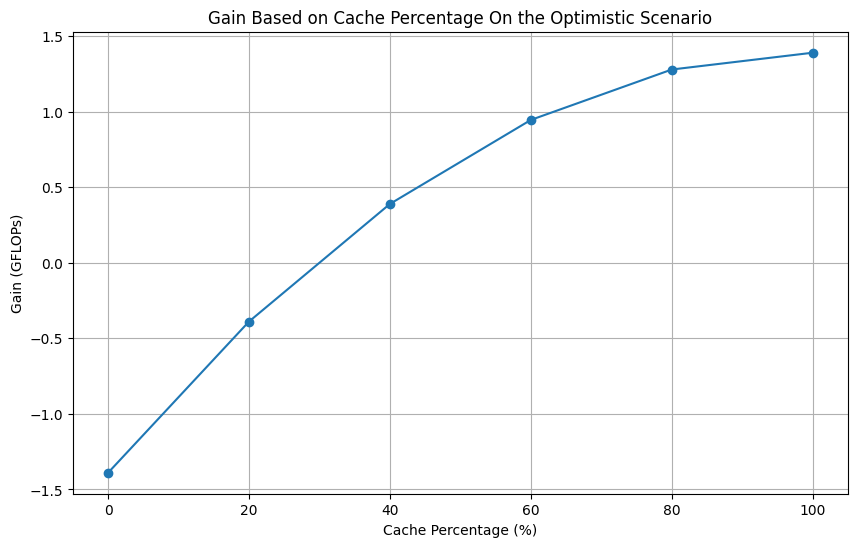

In [35]:
import matplotlib.pyplot as plt

# Percentages of caching
cache_percentages = [0, 20, 40, 60, 80, 100]
# Calculate the corresponding gains based on the normal model cost
gains = [
    normal_model_cost - (calculate_flops(layers, uncached_percent=(1 - cp / 100.0))[1] + student_model_cost)
    for cp in cache_percentages
]

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(cache_percentages, [gain / 1e9 for gain in gains], marker='o')
plt.title('Gain Based on Cache Percentage On the Optimistic Scenario')
plt.xlabel('Cache Percentage (%)')
plt.ylabel('Gain (GFLOPs)')
plt.grid()
plt.xticks(cache_percentages)
plt.show()
